In [19]:
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [20]:
# Hyper Parameters
EPOCH = 10           
BATCH_SIZE = 32
LR = 0.001       

In [21]:
# Define a transform with augmentation for training data
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Random affine
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
test_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
dataset = datasets.ImageFolder(root='../data', transform=train_transforms)
dataset

Dataset ImageFolder
    Number of datapoints: 4188
    Root location: ../data
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [24]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Apply the transformations to the test dataset
test_dataset.dataset.transform = test_transforms

In [25]:
# Calculate class weights for WeightedRandomSampler
class_weights = compute_class_weight('balanced', classes=np.unique(dataset.targets), y=[y for _, y in train_dataset])
sample_weights = torch.from_numpy(np.array([class_weights[t] for _, t in train_dataset]))

# Create a WeightedRandomSampler for the training data loader
sampler = WeightedRandomSampler(weights=sample_weights.type('torch.DoubleTensor'), num_samples=len(sample_weights), replacement=True)


In [26]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [28]:
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)
model = model.to(device)

/Users/qianqian/anaconda3/envs/KaggleChallenge/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qianqian/anaconda3/envs/KaggleChallenge/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# optimizer and crossEntropy
optimizer = optim.Adam(model.parameters(), lr=LR)   
loss_func = nn.CrossEntropyLoss()   

In [31]:
# training
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   
        output = model(b_x)               
        loss = loss_func(output, b_y)   
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()                

        if step % 50 == 0:
            print(f'Epoch: {epoch}, Step: {step}, Loss: {loss.item()}')

Epoch: 0, Step: 0, Loss: 1.6856679916381836
Epoch: 0, Step: 50, Loss: 0.14951986074447632


In [34]:
# test all
model.eval()
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


In [37]:
from sklearn.metrics import classification_report

# Assuming 'true_labels' and 'predicted_labels' are lists of true and predicted labels from your test dataset
print(classification_report(true_labels, predicted_labels, target_names=dataset.classes))


                precision    recall  f1-score   support

        Blight       0.81      0.81      0.81       337
   Common_Rust       0.96      0.94      0.95       403
Gray_Leaf_Spot       0.66      0.70      0.68       170
       Healthy       0.99      0.99      0.99       347

      accuracy                           0.88      1257
     macro avg       0.85      0.86      0.86      1257
  weighted avg       0.89      0.88      0.89      1257



In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'true_labels' and 'predicted_labels' are lists of true and predicted labels from your test dataset
cm = confusion_matrix(true_labels, predicted_labels)

In [48]:
cm

array([[274,   8,  53,   2],
       [ 15, 377,   9,   2],
       [ 46,   5, 119,   0],
       [  3,   2,   0, 342]])

/var/folders/l8/91v4g58n2qqb08ykk4br86xw0000gn/T/ipykernel_81556/3603747079.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + class_names)
/var/folders/l8/91v4g58n2qqb08ykk4br86xw0000gn/T/ipykernel_81556/3603747079.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + class_names)


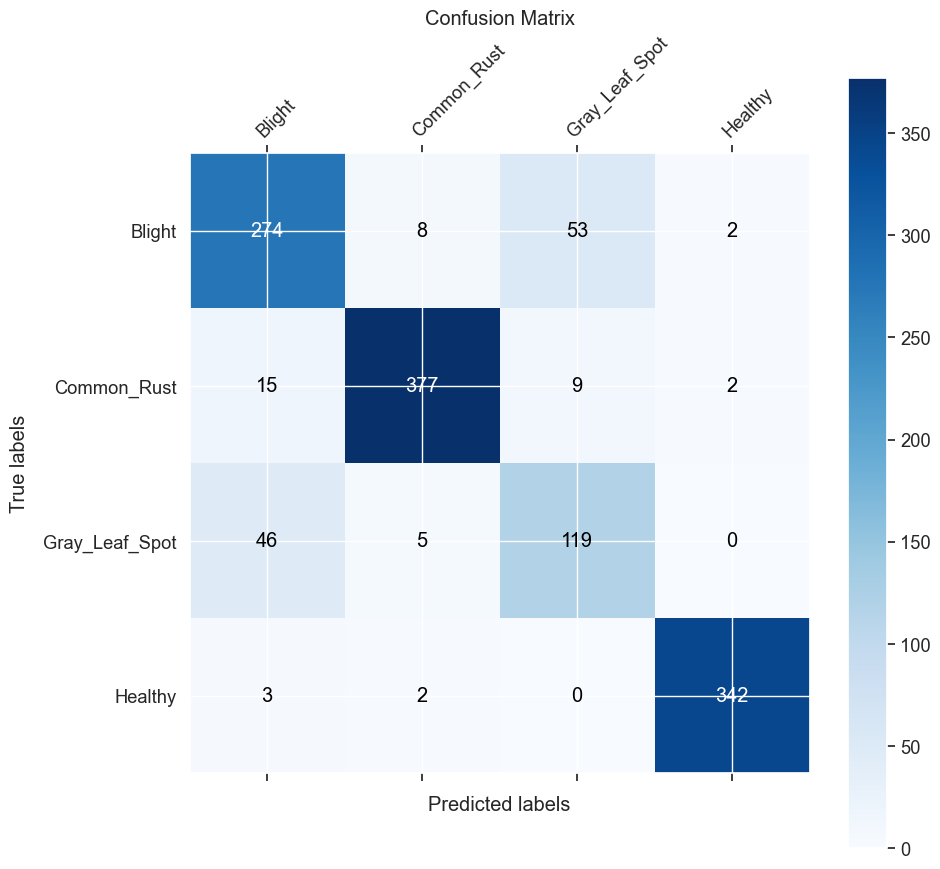

In [65]:
# Get class names from the dataset
class_names = dataset.classes  # Adjust this to match your dataset's class names

fig, ax = plt.subplots(figsize=(10, 10))
cax = ax.matshow(cm, cmap=plt.cm.Blues)

# Add color bar for reference
fig.colorbar(cax)

# Set axis labels
ax.set_xlabel('Predicted labels', labelpad=10)
ax.set_ylabel('True labels', labelpad=10)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

# Rotate the x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Annotate each cell with the numeric value
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")

plt.title('Confusion Matrix')
plt.show()


In [ ]:
# testing
test_x, test_y = next(iter(test_loader))
test_output = model(test_x)
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y.numpy(), 'real number')